In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('BF_df_CTU.csv')
data.head()

,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION
0,4,4,4,4,4,5,4,4,4,4,H
1,4,2,2,4,4,5,3,4,4,4,H
2,4,2,2,4,4,4,3,4,4,4,H
3,4,2,2,4,2,4,5,5,4,2,H
4,3,2,3,4,5,5,4,4,5,5,H


In [22]:
n=len(data)

In [24]:
x_real = data.iloc[:n//2,:-1]
x_fake = data.iloc[n//2:,:-1]

In [25]:
index = np.random.choice([0,1,2], size=n//2, p=[0.8,0.1,0.1])

In [36]:
x_real_train = x_real[index==0]
x_real_val = x_real[index==1]
x_real_test = x_real[index==2]

x_fake_train = x_fake[index==0]
x_fake_val = x_fake[index==1]
x_fake_test = x_fake[index==2]

# Naive approach

All the proposed method should outperform the trivial strategy of subtracting to each subject faked response the average of the difference, across all subjects, among faked and honest response.

In [81]:
mean_train = (x_fake_train.to_numpy() - x_real_train.to_numpy()).mean(axis=0)
test_mse = (((x_fake_test.subtract(mean_train)).to_numpy() - x_real_test.to_numpy())**2).mean()
test_mse

1.5893010983461682

# Denoising autoencoder

In [37]:
ENCODING_DIM = 4

input_vector = tf.keras.layers.Input(shape=(10,))

# Define the encoder
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_vector)

# ...and the decoder...
decoded = tf.keras.layers.Dense(10, activation='sigmoid')(encoded)

# and finally the autoencoder
autoencoder = tf.keras.models.Model(inputs=input_vector, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [19]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 44        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = autoencoder.fit(x_fake_train, x_real_train, epochs=30, shuffle=True, validation_data=(x_fake_val, x_real_val))

Epoch 1/30
6/6 [==============================] - 0s 34ms/step - loss: 9.2126 - val_loss: 9.1555
Epoch 2/30
6/6 [==============================] - 0s 6ms/step - loss: 9.1620 - val_loss: 9.1066
Epoch 3/30
6/6 [==============================] - 0s 7ms/step - loss: 9.1106 - val_loss: 9.0574
Epoch 4/30
6/6 [==============================] - 0s 8ms/step - loss: 9.0589 - val_loss: 9.0079
Epoch 5/30
6/6 [==============================] - 0s 7ms/step - loss: 9.0077 - val_loss: 8.9583
Epoch 6/30
6/6 [==============================] - 0s 8ms/step - loss: 8.9569 - val_loss: 8.9093
Epoch 7/30
6/6 [==============================] - 0s 8ms/step - loss: 8.9071 - val_loss: 8.8614
Epoch 8/30
6/6 [==============================] - 0s 7ms/step - loss: 8.8591 - val_loss: 8.8149
Epoch 9/30
6/6 [==============================] - 0s 9ms/step - loss: 8.8133 - val_loss: 8.7702
Epoch 10/30
6/6 [==============================] - 0s 9ms/step - loss: 8.7694 - val_loss: 8.7277
Epoch 11/30
6/6 [=====================

In [33]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

1/1 - 0s - loss: 8.3600
test mse: 8.36001


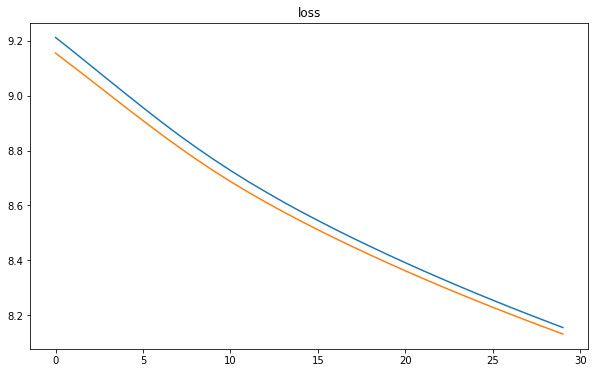

In [39]:
plot_loss(history)

scores = autoencoder.evaluate(x_fake_test, x_real_test, verbose=2)
print("test mse: %.5f" % (scores))